<h1 style="text-align: center;" markdown="3">Machine Learning 2: Naive Bayes Classifier</h1> 

# Table of Contents
[Introduction](#introduction)  
[Naive Bayes](#naive-bayes)  
&nbsp;&nbsp;&nbsp;[Undersampling](#undersampling)  
&nbsp;&nbsp;&nbsp;[Oversampling](#oversampling)  
&nbsp;&nbsp;&nbsp;[Tune Parameters and Cross-Validate](#tune-cv)  
[Calibration with Platt Scaling](#calibration)  
[Feature Selection](#feature-selection)  
[Summary](#summary)

# Introduction <a class="anchor" id="introduction"></a>

[Naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) classifiers are fast, easy to implement, and therefore often used as a first-pass model for classification tasks. The _naivety_ in the name is due to the assumption that the features of the data are conditionally independent of one another given the class label. This idependence assumption leads to a closed-form maximum likelihood estimation, model complexity that is linear in the number of features, and the statistical advantage that less data is required to obtain useful estimates of model parameters. Because of these conveniences, Naive Bayes models are commonly used as a baseline in natural language processing applications such as document classification, spam filtering, or sentiment analysis. But the speed and simplicity of the model make it a worthwhile consideration for any classification task.

## Consideration.
__Advantages__
 - It is easy and fast to predict the class of the test data set. It also performs well in multi-class prediction.
 - When assumption of independence holds, a Naive Bayes classifier performs better compare to other models like logistic regression and you need less training data.
 - It perform well in case of categorical input variables compared to numerical variable(s). For numerical variable, normal distribution is assumed (bell curve, which is a strong assumption).
 
__Disadvantages__

- If categorical variable has a category (in test data set), which was not observed in training data set, then model will assign a 0 (zero) probability and will be unable to make a prediction. This is often known as [Zero Frequency](https://datascience.stackexchange.com/questions/15526/how-to-handle-a-zero-factor-in-naive-bayes-classifier-calculation). To solve this, we can use the smoothing technique. One of the simplest smoothing techniques is called [Laplace](https://www.quora.com/How-does-Laplacian-add-1-smoothing-work-for-a-Naive-Bayes-classfier-algorithm) estimation.
- On the other side naive Bayes is also known as a bad estimator, so the probability outputs are not to be taken too seriously.
- Another limitation of Naive Bayes is the assumption of independent predictors. In real life, it is almost impossible that we get a set of predictors which are completely independent.

## Data setup

As usual, we'll load a the libraries and the data that will be used throughout this notebook. 

In [1]:
# Data importation and manipulation tools
import numpy as np
import pandas as pd
import itertools

# Data visualization tools
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

# Machine Learning tools
from sklearn.linear_model import LogisticRegression

# Metrics
from sklearn.metrics import (
    confusion_matrix,
    log_loss,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    cohen_kappa_score,
    roc_curve,
    auc
)

In [2]:
# load training data 
lcs_train = pd.read_pickle("Data/processed/train.pkl")

# Separate features
X_train = lcs_train.drop(['Persns_wgt', 'sick'], axis=1)
y_train = lcs_train['sick']
w_train = lcs_train['Persns_wgt']

# summarize loaded data
print('Data has {:,} rows and {:,} columns' \
        .format(*X_train.shape))

print('Percent sick: {:0.1%} \tPercent non-sick: {:0.1%}' \
        .format(*y_train.value_counts(normalize=True, ascending=True)))

# Load test data
lcs_test = pd.read_pickle("Data/processed/test.pkl")

# Separate features
X_test = lcs_test.drop(['Persns_wgt', 'sick'], axis=1)
y_test = lcs_test['sick']
y_test = np.ravel(y_test)
w_test = lcs_test['Persns_wgt']

# print first 5 rows of data
X_train.head()

Data has 39,075 rows and 236 columns
Percent sick: 15.9% 	Percent non-sick: 84.1%


,Q14AGE,Q613BED,Q615KITCHEN,Q616BATH,Q617TOILET,Q161APUBATT,Q161APRIVATT,hhsize,expenditure_pcp,pcnetincome,...,Q221DHEALTH__More than adequate,Q224ANOMONEY__Yes,Q224BNOMONEY5__Yes,Q225ASIZE__Yes,Q225BSIZE5__Yes,Q226ASKIP__Yes,Q226BSKIP5__Yes,Q227ALESS__Yes,Q227BLESS5__Yes,SexOfHead__Male
UQNO,,,,,,,,,,,,,,,,,,,,,
920002240000007301,48,2,0,0,0,0,0,5,3664.148804,400,...,0,0,0,0,0,0,0,0,0,1
417000450000011901,27,0,0,0,0,0,0,4,11451.292500,1250,...,0,0,0,0,0,1,0,1,0,1
107002150000030901,3,1,1,0,0,3,0,6,6066.745258,1000,...,0,1,0,1,0,1,0,1,0,1
919005240000017601,0,1,1,1,0,0,0,3,28007.446415,2620,...,0,0,0,0,0,0,0,0,0,1
983000120000022201,4,3,1,0,0,0,0,7,1727.626033,285,...,0,0,0,0,0,0,0,0,0,0


We standardize the data

In [3]:
# Standardize features
def standardize(df):
    cols = df.loc[:, df.dtypes != 'uint8'].columns
    for field in cols:
        mean, std = df[field].mean(), df[field].std()
        # account for constant columns
        if np.all(df[field] - mean != 0):
            df.loc[:, field] = (df[field] - mean) / std
    
    return df

standardize(X_train)
standardize(X_test)
X_train.head()

,Q14AGE,Q613BED,Q615KITCHEN,Q616BATH,Q617TOILET,Q161APUBATT,Q161APRIVATT,hhsize,expenditure_pcp,pcnetincome,...,Q221DHEALTH__More than adequate,Q224ANOMONEY__Yes,Q224BNOMONEY5__Yes,Q225ASIZE__Yes,Q225BSIZE5__Yes,Q226ASKIP__Yes,Q226BSKIP5__Yes,Q227ALESS__Yes,Q227BLESS5__Yes,SexOfHead__Male
UQNO,,,,,,,,,,,,,,,,,,,,,
920002240000007301,0.955936,-0.414011,-1.395383,-0.582252,-0.528091,-0.298658,-0.286177,-0.157885,-0.431979,-0.283026,...,0,0,0,0,0,0,0,0,0,1
417000450000011901,-0.052461,-1.779027,-1.395383,-0.582252,-0.528091,-0.298658,-0.286177,-0.489928,-0.258849,-0.141051,...,0,0,0,0,0,1,0,1,0,1
107002150000030901,-1.204916,-1.096519,0.262655,-0.582252,-0.528091,1.359649,-0.286177,0.174158,-0.378563,-0.182809,...,0,1,0,1,0,1,0,1,0,1
919005240000017601,-1.348973,-1.096519,0.262655,0.617089,-0.528091,-0.298658,-0.286177,-0.821970,0.109240,0.087779,...,0,0,0,0,0,0,0,0,0,1
983000120000022201,-1.156897,0.268497,0.262655,-0.582252,-0.528091,-0.298658,-0.286177,0.506200,-0.475034,-0.302234,...,0,0,0,0,0,0,0,0,0,0


## Metrics functions
Let's also create our functions for the evaluation of models.

In [4]:
# Create the ROC plot function
def plot_roc(y_test, y_pred, y_prob, model, ax, sample_weights=None):
    
    # dictionnary of metrics to calculate
    fpr, tpr, _ = roc_curve(y_test, y_prob, sample_weight=sample_weights)
    metrics = {}
    metrics['fpr'] = fpr
    metrics['tpr'] = tpr
    metrics['roc_auc'] = roc_auc_score(y_test,y_prob, sample_weight=sample_weights)
    
    # Create graph with Legend
    ax= ax
    ax.plot(metrics['fpr'], metrics['tpr'], label='{} AUC = {:0.2f}'.format(model, metrics['roc_auc']))
    
    # Specification of Graph
    ax.set_title('Receiver Operating Characteristic')
    ax.plot([0,1],[0,1],'k--')
    ax.set_xlim([-0.01,1])
    ax.set_ylim([0,1.01])
    ax.legend(loc='lower right')
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    return

# Create the confusion matrix plot function
# Derived from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(y_test, y_pred,ax, sample_weight = None):
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred, sample_weight=None)
    # Reverse the results
    cm = cm[::-1,::-1]

    # Create plot
    ax = ax
    tick_marks = np.arange(2)
    ax.set_title('Confusion matrix')
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(["sick", "non-sick"])
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(["sick","non-sick"])
    ax.grid(False)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

    # Create font and color bar
    im = ax.imshow(cm, interpolation='nearest', cmap= plt.cm.Blues)
    fig.colorbar(im, ax=ax, shrink=0.7)

    # Create normalized and text results
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        txt = "{:.0f}".format(cm[i,j])
        txt = txt + "\n{:0.1%}".format(cm_norm[i,j])
        ax.text(j, i, txt, fontsize=14, fontweight='bold',
                     horizontalalignment="center", verticalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    return


# Create a DataFrame to store de model results
model_score = pd.DataFrame(index = ['accuracy','recall','precision','f1','roc_auc','cross_entropy','cohen_kappa'])

# Define a function to show metrics in a DataFrame
def get_metrics(y_test, y_pred, model_name, sample_weights=None): 
    # Show metrics values
    model_scores = {}

    model_scores['accuracy']          = accuracy_score(y_test, y_pred, sample_weight=sample_weights)
    model_scores['recall']            = recall_score(y_test, y_pred, sample_weight=sample_weights)
    model_scores['precision']         = precision_score(y_test, y_pred, sample_weight=sample_weights)
    model_scores['f1']                = f1_score(y_test, y_pred, sample_weight=sample_weights)
    model_scores['roc_auc']           = roc_auc_score(y_test,y_prob, sample_weight=sample_weights)
    model_scores['cross_entropy']     = log_loss(y_test,y_prob,sample_weight=sample_weights)
    model_scores['cohen_kappa']       = cohen_kappa_score(y_test, y_pred)

    print("Model Scores")
    print("Actual sick rate: {:0.2%}".format(y_test.sum()/len(y_test)))
    print("Predicted sick rate: {:0.2%}".format(y_pred.sum()/len(y_pred)))
    model_score[model_name] = model_score.index.map(model_scores)
    return model_score

# Naive Bayes model <a class="anchor" id="naive-bayes"></a>
Now let's apply the Naive Bayes classifier to the dataset. We will use the [BernoulliNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html) classifier because it is designed for binary/boolean features. As all sklearn classifiers, the process is the same.

In [5]:
from sklearn.naive_bayes import BernoulliNB

# Fit the model
model = BernoulliNB()
%time model.fit(X_train, y_train, sample_weight = w_train)

# Get an initial score
%time score = model.score(X_train, y_train, sample_weight = w_train)
print("In-sample score: {:0.2%}".format(score))

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

CPU times: user 110 ms, sys: 67.2 ms, total: 177 ms
Wall time: 140 ms
CPU times: user 153 ms, sys: 284 ms, total: 438 ms
Wall time: 103 ms
In-sample score: 85.21%


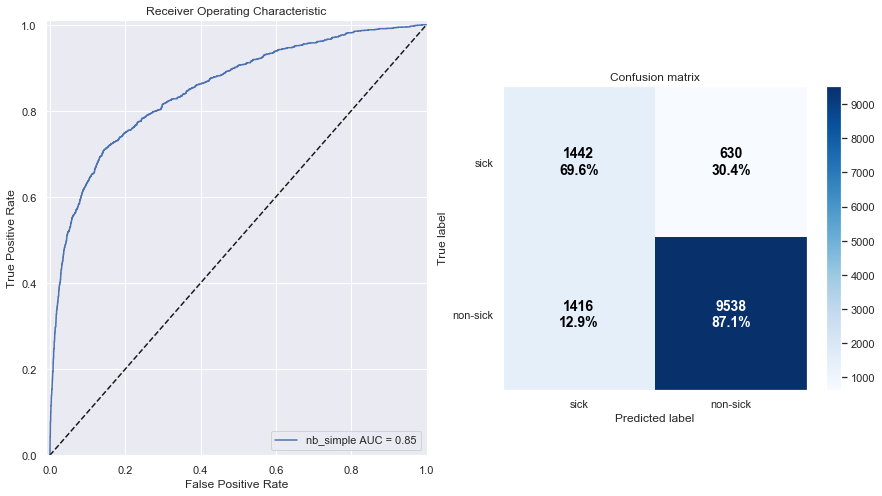

Model Scores
Actual sick rate: 15.91%
Predicted sick rate: 21.94%


,nb_simple
accuracy,0.850969
recall,0.655249
precision,0.478448
f1,0.553062
roc_auc,0.849767
cross_entropy,0.639953
cohen_kappa,0.491143


In [6]:
# Show plot of metrics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,8))
plot_roc(y_test, y_pred, y_prob, "nb_simple", ax= axes[0], sample_weights= w_test)
plot_confusion_matrix(y_test, y_pred, ax= axes[1])
plt.show()
get_metrics(y_test, y_pred, 'nb_simple', sample_weights = w_test)

The overall accuracy of the model is a bit better than our baseline. The recall is alright but the precision rate is low. It means that we are incorrectly classifying a large percentage of healthy individual as sick. We see that we have predicted about 22% of the population as sick although only 16% of them are really sick. Let's try our balanced method to see if we could improve the model.

## Undersampling <a class="anchor" id="undersampling">
    
Now we'll apply undersampling and see how the performance is affected.

In [7]:
from imblearn.under_sampling import RandomUnderSampler

# Apply random undersampling
X_train_u, y_train_u = RandomUnderSampler().fit_sample(X_train, y_train)
print("X shape after undersampling: ", X_train_u.shape)

# Fit the model
model = BernoulliNB()
%time model.fit(X_train_u, y_train_u)

# Get an initial score
%time score = model.score(X_train_u, y_train_u)
print("In-sample score: {:0.2%}".format(score))

# Run the model
%time y_pred_u = model.predict(X_test)
%time y_prob_u = model.predict_proba(X_test)[:,1]

Using TensorFlow backend.


X shape after undersampling:  (12430, 236)
CPU times: user 24.8 ms, sys: 2.01 ms, total: 26.8 ms
Wall time: 24 ms
CPU times: user 42.1 ms, sys: 10.2 ms, total: 52.3 ms
Wall time: 21.6 ms
In-sample score: 78.43%
CPU times: user 53.2 ms, sys: 110 ms, total: 164 ms
Wall time: 32.7 ms
CPU times: user 51.6 ms, sys: 105 ms, total: 157 ms
Wall time: 27.3 ms


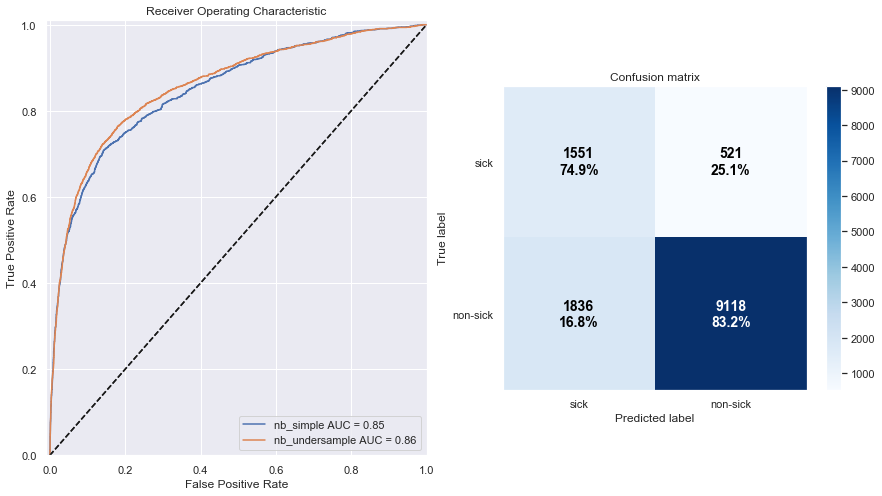

Model Scores
Actual sick rate: 15.91%
Predicted sick rate: 26.00%


,nb_simple,nb_undersample
accuracy,0.850969,0.819054
recall,0.655249,0.748552
precision,0.478448,0.457927
f1,0.553062,0.568236
roc_auc,0.849767,0.859324
cross_entropy,0.639953,0.697344
cohen_kappa,0.491143,0.462054


In [8]:
# Show plot of metrics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,8))
plot_roc(y_test, y_pred, y_prob, "nb_simple", ax= axes[0], sample_weights= w_test)
plot_roc(y_test, y_pred_u, y_prob_u, "nb_undersample", ax= axes[0])
plot_confusion_matrix(y_test, y_pred_u, ax= axes[1])
plt.show()
get_metrics(y_test, y_pred_u, 'nb_undersample')

This actually traded a bit of accuracy for recall but the precision is still very low.

## Oversampling <a class="anchor" id="oversampling">

In [9]:
from imblearn.over_sampling import SMOTE

# Apply random undersampling
X_train_o, y_train_o = SMOTE().fit_sample(X_train, y_train)
print("X shape after undersampling: ", X_train_o.shape)

# Fit the model
model = BernoulliNB()
%time model.fit(X_train_o, y_train_o)

# Get an initial score
%time score = model.score(X_train_o, y_train_o)
print("In-sample score: {:0.2%}".format(score))

# Run the model
%time y_pred_o = model.predict(X_test)
%time y_prob_o = model.predict_proba(X_test)[:,1]

X shape after undersampling:  (65720, 236)
CPU times: user 133 ms, sys: 33.9 ms, total: 167 ms
Wall time: 169 ms
CPU times: user 220 ms, sys: 46 ms, total: 266 ms
Wall time: 107 ms
In-sample score: 84.43%
CPU times: user 47.1 ms, sys: 101 ms, total: 148 ms
Wall time: 25.2 ms
CPU times: user 44.4 ms, sys: 96.1 ms, total: 141 ms
Wall time: 25.5 ms


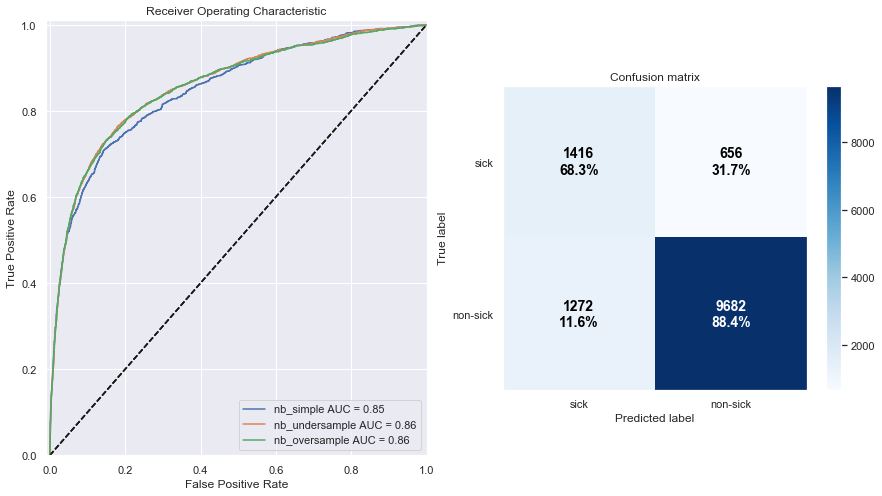

Model Scores
Actual sick rate: 15.91%
Predicted sick rate: 20.64%


,nb_simple,nb_undersample,nb_oversample
accuracy,0.850969,0.819054,0.851988
recall,0.655249,0.748552,0.683398
precision,0.478448,0.457927,0.526786
f1,0.553062,0.568236,0.594958
roc_auc,0.849767,0.859324,0.859324
cross_entropy,0.639953,0.697344,0.697344
cohen_kappa,0.491143,0.462054,0.506256


In [10]:
# Show plot of metrics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,8))
plot_roc(y_test, y_pred, y_prob, "nb_simple", ax= axes[0], sample_weights= w_test)
plot_roc(y_test, y_pred_u, y_prob_u, "nb_undersample", ax= axes[0])
plot_roc(y_test, y_pred_o, y_prob_o, "nb_oversample", ax= axes[0])
plot_confusion_matrix(y_test, y_pred_o, ax= axes[1])
plt.show()
get_metrics(y_test, y_pred_o, 'nb_oversample')

Oversampling increased accuracy and precision, but decreased the recall. F1 is better with the oversampling. As I don't see major improvements with oversampling or undersampling method, I will keep the simple model.

## Tune parameters and cross-validate <a class="anchor" id="tune-cv"></a>

The BernoulliNB model has a single parameter, `alpha`, we can attempt to tune. This is an Additive smoothing parameter, with 0 meaning no smoothing, and the default being 1.0. We can try various ranges of this parameter to see which fits the data best.

In [23]:
from sklearn.model_selection import GridSearchCV

# build the model
estimator = BernoulliNB()
parameters = {'alpha': 10**np.linspace(-5,5,20)}
model = GridSearchCV(estimator, parameters, verbose=1, cv=5)
%time model.fit(X_train, y_train)
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
print("Best model parameters:", model.best_params_)

# Run the model
y_pred_cv = model.predict(X_test)
y_prob_cv = model.predict_proba(X_test)[:,1]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: user 29.8 s, sys: 1min 7s, total: 1min 36s
Wall time: 14.4 s
CPU times: user 134 ms, sys: 272 ms, total: 406 ms
Wall time: 68.7 ms
In-sample score: 86.84%
Best model parameters: {'alpha': 233.57214690901213}


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   14.3s finished


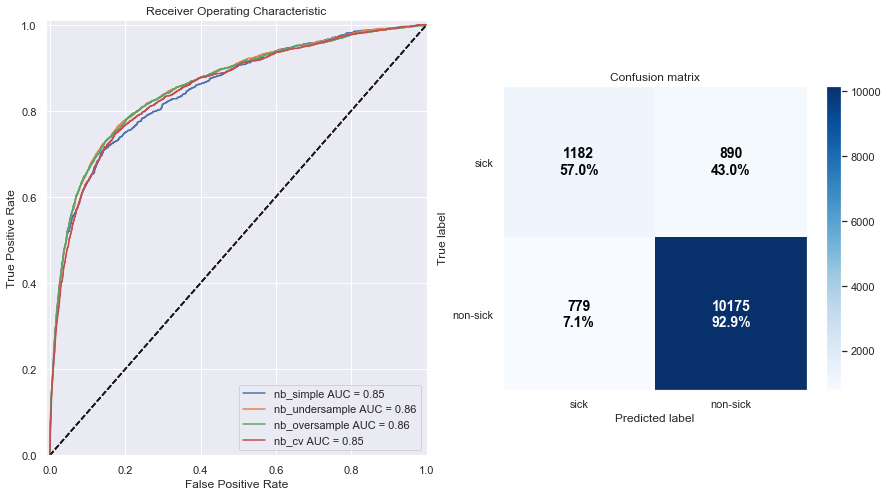

Model Scores
Actual sick rate: 15.91%
Predicted sick rate: 15.05%


,nb_simple,nb_undersample,nb_oversample,nb_cv
accuracy,0.850969,0.819054,0.851988,0.871872
recall,0.655249,0.748552,0.683398,0.570463
precision,0.478448,0.457927,0.526786,0.602754
f1,0.553062,0.568236,0.594958,0.586164
roc_auc,0.849767,0.859324,0.859324,0.859324
cross_entropy,0.639953,0.697344,0.697344,0.697344
cohen_kappa,0.491143,0.462054,0.506256,0.510434


In [24]:
# Show plot of metrics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,8))
plot_roc(y_test, y_pred, y_prob, "nb_simple", ax= axes[0], sample_weights= w_test)
plot_roc(y_test, y_pred_u, y_prob_u, "nb_undersample", ax= axes[0])
plot_roc(y_test, y_pred_o, y_prob_o, "nb_oversample", ax= axes[0])
plot_roc(y_test, y_pred_cv, y_prob_cv, "nb_cv", ax= axes[0])
plot_confusion_matrix(y_test, y_pred_cv, ax= axes[1])
plt.show()
get_metrics(y_test, y_pred_cv, 'nb_cv')

Cross validation for this model has a minor but meaning full impact on performance. We tend to get better recall using undersampling, but better overall performance using oversampling.

Let's see how the accuracy evolves in the train and test set according to the alpha parameter.

In [25]:
# Get the keys of the parameters
model.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_alpha', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [26]:
# Collect results in a DataFrame
cv_results = pd.DataFrame(model.cv_results_)

# Print a few interesting columns
cols = ['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'param_alpha']
cv_results[cols].sort_values('mean_test_score', ascending=False)

/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=T

,mean_test_score,std_test_score,mean_train_score,std_train_score,param_alpha
14,0.870250,0.003044,0.870262,6.693739e-04,233.572
15,0.858836,0.001521,0.859072,3.425146e-04,784.76
13,0.857633,0.001699,0.857921,1.021791e-03,69.5193
12,0.852233,0.002602,0.853161,1.157198e-03,20.6914
11,0.851107,0.002111,0.852067,1.221758e-03,6.15848
0,0.850749,0.002147,0.851708,1.142102e-03,1e-05
2,0.850749,0.002147,0.851708,1.142102e-03,0.000112884
3,0.850749,0.002147,0.851708,1.142102e-03,0.000379269
4,0.850749,0.002147,0.851708,1.142102e-03,0.00127427
5,0.850749,0.002147,0.851708,1.142102e-03,0.00428133


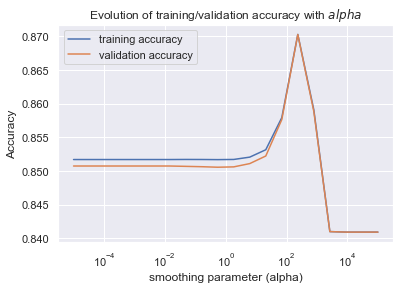

In [28]:
# Plot training/validation accuracy curves
plt.semilogx(cv_results["param_alpha"], cv_results["mean_train_score"], label='training accuracy')
plt.semilogx(cv_results["param_alpha"], cv_results["mean_test_score"],  label='validation accuracy')
plt.xlabel('smoothing parameter (alpha)')
plt.ylabel('Accuracy')
plt.title("Evolution of training/validation accuracy with $alpha$")
plt.legend()
plt.show()

There seems to be an ideal smoothing parameter around 250. From 50, the accuracy of the test set joins the train set. However, the accuracy decreases abruptly after a certain point, perhaps a sign of overfitting. It would therefore be wise not to exceed a smoothing parameter of 100 to avoid overfitting.

# Classifier Calibration - Platt Scaling <a class="anchor" id="calibration"></a>

One shortfall of Naive Bayes is that it is a poor estimator of probability, even if it serves as a good classifier. One method to improve the probability predictions is to apply calibration. Scikit-Learn provides a method for us to easily apply calibration to a classifier along with cross-validation. The two most popular calibration methods are "Platt Scaling" (also known as "Sigmoid Scaling") and "Isotonic Regression". Here, we will apply Platt scaling to the model.

**platt scaling** http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html

**help with cccv** https://stats.stackexchange.com/questions/263393/scikit-correct-way-to-calibrate-classifiers-with-calibratedclassifiercv

In [13]:
# platt scaling
from sklearn.calibration import CalibratedClassifierCV

# Calibrate the model
model = CalibratedClassifierCV(model.best_estimator_, method='sigmoid')
%time model.fit(X_train, y_train)
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Run the model
y_pred_cv_platt = model.predict(X_test)
y_prob_cv_platt = model.predict_proba(X_test)[:,1]

/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


CPU times: user 473 ms, sys: 781 ms, total: 1.25 s
Wall time: 251 ms
CPU times: user 365 ms, sys: 716 ms, total: 1.08 s
Wall time: 232 ms
In-sample score: 87.27%


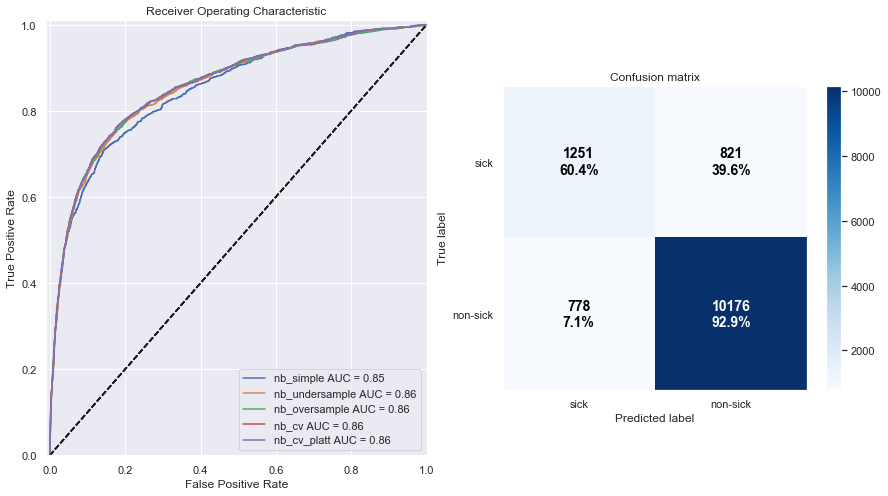

Model Scores
Actual sick rate: 15.91%
Predicted sick rate: 15.58%


,nb_simple,nb_undersample,nb_oversample,nb_cv,nb_cv_platt
accuracy,0.850969,0.812222,0.852372,0.854522,0.877246
recall,0.655249,0.756274,0.682915,0.689189,0.603764
precision,0.478448,0.446693,0.527788,0.533035,0.616560
f1,0.553062,0.561649,0.595413,0.601137,0.610095
roc_auc,0.849767,0.859324,0.859324,0.859324,0.859324
cross_entropy,0.639953,0.697344,0.697344,0.697344,0.697344
cohen_kappa,0.491143,0.452060,0.506934,0.513943,0.537261


In [14]:
# Show plot of metrics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,8))
plot_roc(y_test, y_pred, y_prob, "nb_simple", ax= axes[0], sample_weights= w_test)
plot_roc(y_test, y_pred_u, y_prob_u, "nb_undersample", ax= axes[0])
plot_roc(y_test, y_pred_o, y_prob_o, "nb_oversample", ax= axes[0])
plot_roc(y_test, y_pred_cv, y_prob_cv, "nb_cv", ax= axes[0])
plot_roc(y_test, y_pred_cv_platt, y_prob_cv_platt, "nb_cv_platt", ax= axes[0])
plot_confusion_matrix(y_test, y_pred_cv_platt, ax= axes[1])
plt.show()
get_metrics(y_test, y_pred_cv_platt, 'nb_cv_platt')

The calibration increase accuracy and precision but decrease the recall. We see that the cross_entropy is higher than the logistic regression, which proves that Naive Bayes models does not give very accurate probability estimates.


# Naive Bayes Summary <a class="anchor" id="summary"></a>

In [15]:
# Inverse the cross entropy values
model_eval = model_score.copy()
model_eval[model_eval.index == 'cross_entropy'] = 1 - model_eval[model_eval.index == 'cross_entropy']

model_eval.mean().sort_values(ascending = False)

nb_cv_platt       0.629558
nb_cv             0.621972
nb_oversample     0.618200
nb_simple         0.605527
nb_undersample    0.598697
dtype: float64

In [16]:
# Store the results in a pickle file
model_score.to_pickle("models/nb.pkl")